In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [3]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
v = [0.01, 0.001, 0.2, 0.2]

# Desired trajectory

In [4]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [5]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [6]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [7]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [8]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

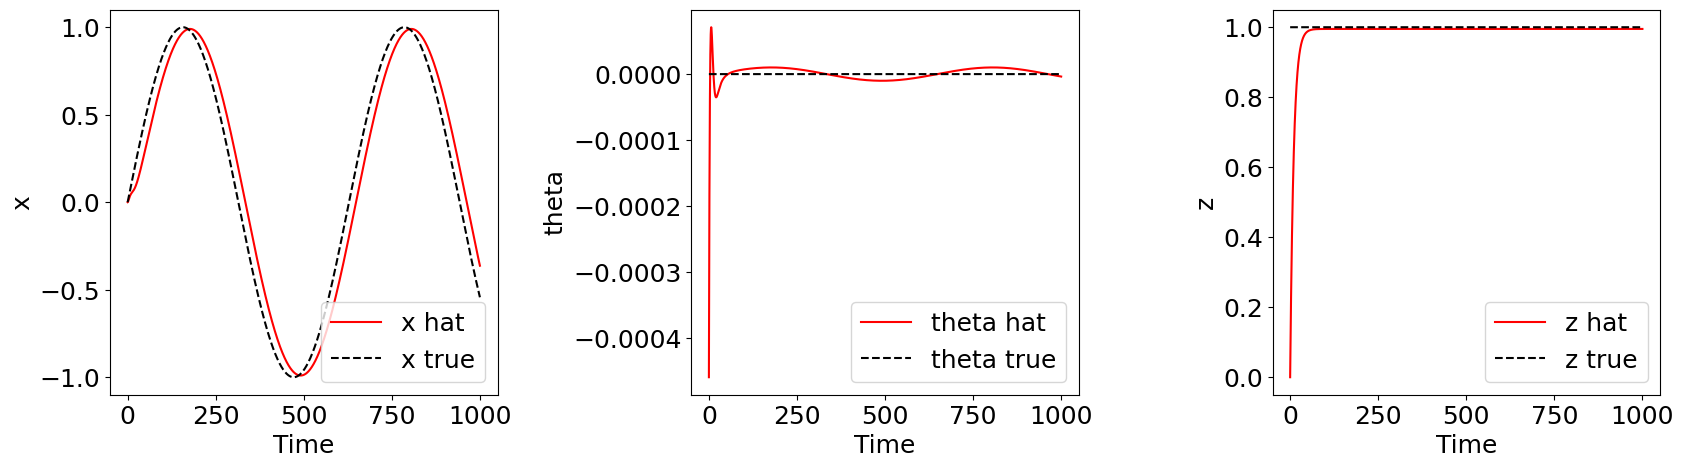

In [9]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [10]:
def h(x, v):
    theta, thetadot, x, xdot, z, zdot = x
    
    y = np.array([theta, thetadot, x, z])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [11]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T

<Axes: xlabel='Time', ylabel='z'>

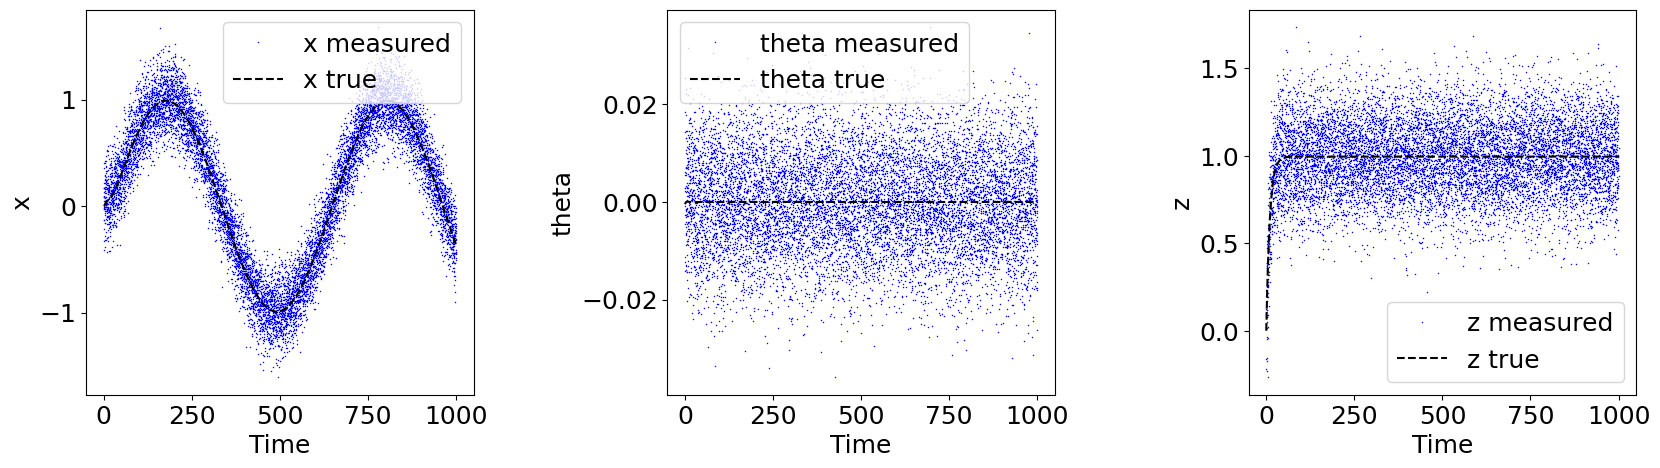

In [12]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

# Discrete Linearized

In [13]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau

In [14]:
dt = np.mean(np.diff(t))

A = np.array([[1,        dt, 0, 0,  0, 0],
              [0,        1,  0, 0,  0, 0],
              [0,        0,  1, dt, 0, 0],
              [-F0/m*dt, 0,  0, 1,  0, 0],
              [0,        0,  0, 0,  1, dt],
              [0,        0,  0, 0,  0, 1]])

B = np.array([[0,      0],
              [0,      1/I*dt],
              [0,      0],
              [0,      0],
              [0,      0],
              [1/m*dt, 0]])

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

D = np.zeros([4, 2])

# Organize some inputs for the KF

In [15]:
# get the control inputs -- these should be known
u = control_linear(X, t)
u = np.vstack(u)

# R is determined by the variance, thus the square of the standard deviation
R = np.diag(v)**2

# Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
# But they can be led astray, and are slower to converge 
Q = 1e-11*np.eye(6)

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(6)]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(6)

# Run the KF

In [16]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [17]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [18]:
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C, R, Q)

In [19]:
theta_hat = xhat_fp[0, :]
x_hat = xhat_fp[2, :]
z_hat = xhat_fp[4, :]

<Axes: xlabel='Time', ylabel='z'>

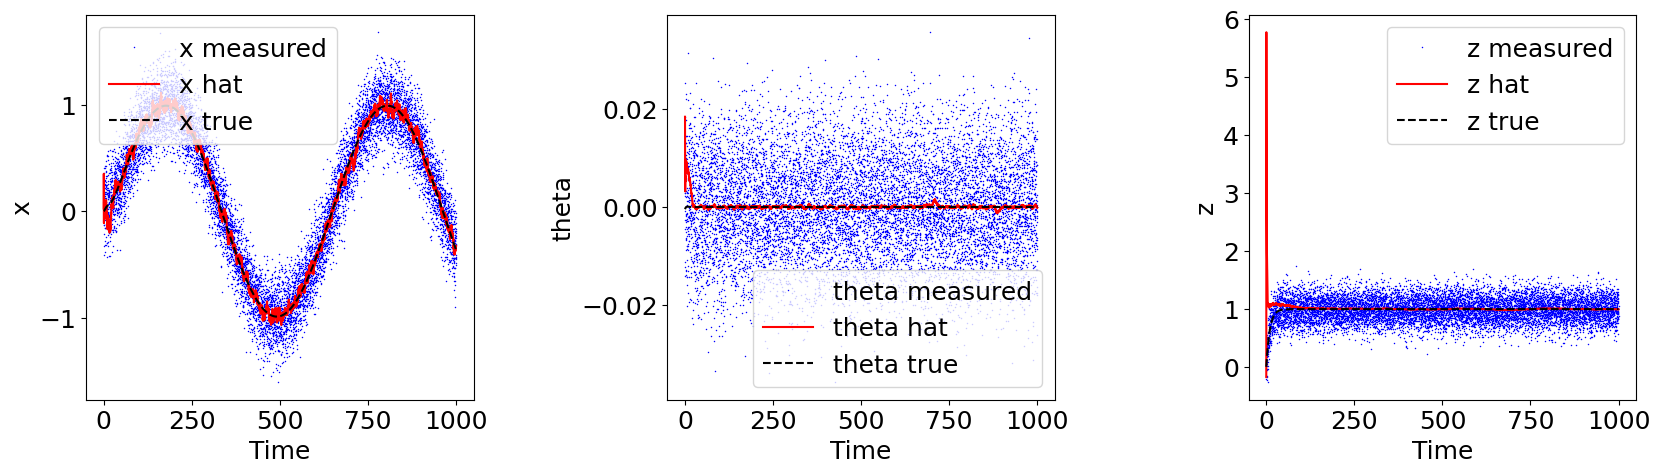

In [20]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], z_hat, label_var='z', ax=ax3)

In [21]:
theta_dot_hat = xhat_fp[1, :]
x_dot_hat = xhat_fp[3, :]
z_dot_hat = xhat_fp[5, :]

theta_dot = X[1, :]
x_dot = X[3, :]
z_dot = X[5, :]

(-0.05, 0.05)

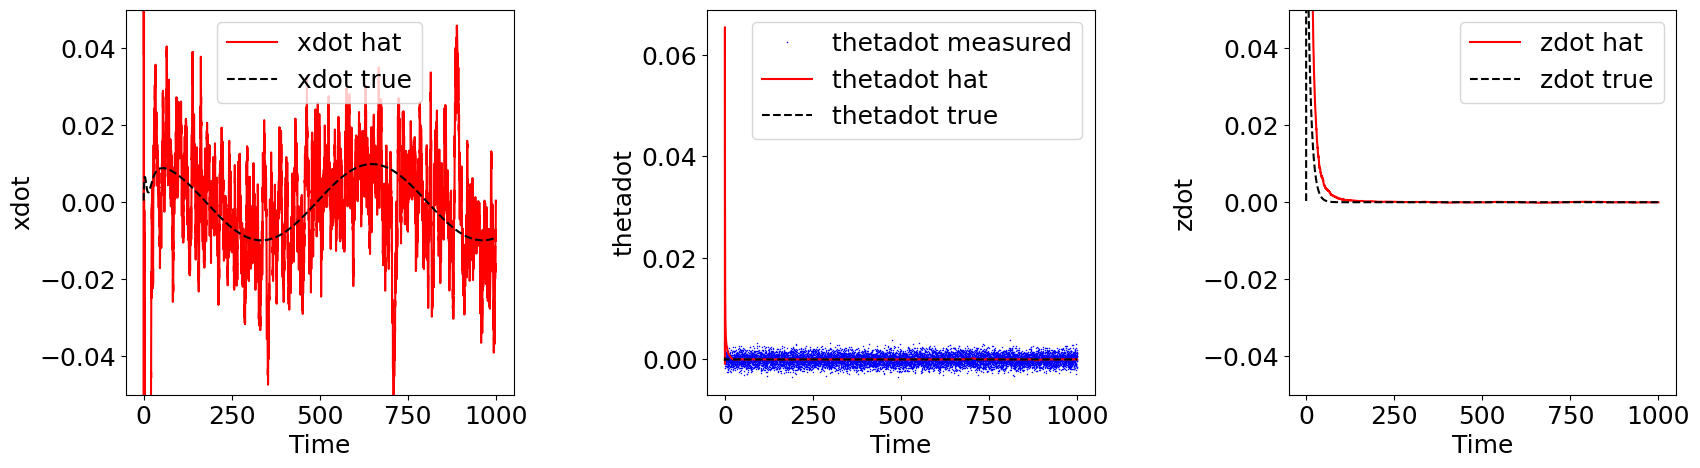

In [22]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_dot, None, x_dot_hat, label_var='xdot', ax=ax1)
ax1.set_ylim(-.05, 0.05)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_dot, Y[1,:], theta_dot_hat, label_var='thetadot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_dot, None, z_dot_hat, label_var='zdot', ax=ax3)
ax3.set_ylim(-.05, 0.05)

# Analyze the error

Focus on state x

In [23]:
# Covariance for state x

Px = np.dstack(P_fp)[2,2,:]

Recall that P is the covariance, so its diagonals are the variance. Variance = (Standard Deviation)^2.


In theory, the errors in the estimates should be well approximated by a Normal distribution with zero mean and standard deviation determined by the diagonal element of P. Lets see.

Text(0, 0.5, 'frequency')

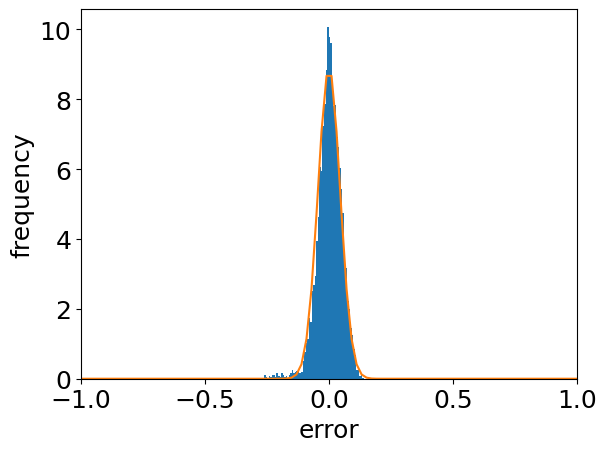

In [24]:
import scipy.stats

xr = np.linspace(-1, 1, 100)
N = scipy.stats.norm(0, np.mean(Px)**0.5 )
pdf = N.pdf(xr)

plt.hist(x_hat-x, bins=100, density=True)
plt.plot(xr, pdf)

plt.xlim(-1,1)

plt.xlabel('error')
plt.ylabel('frequency')

Furthermore, 97.7% of the errors should lie under the 3*$\sigma$ bounds. Let's see. 

Text(0, 0.5, 'error')

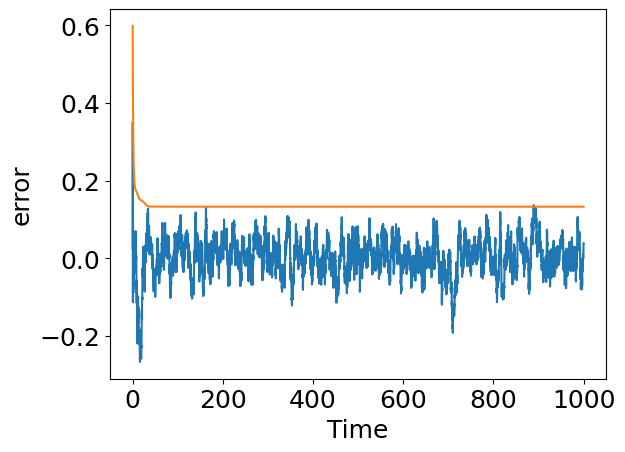

In [25]:
sigma = Px**0.5

plt.plot(t, x_hat-x)
plt.plot(t, 3*sigma)

plt.xlabel('Time')
plt.ylabel('error')

# Analyze error for all states once filter converged

Look at the correlation of the error covariance matrix vs the std dev of the error and mean abs error for each state. 

In [26]:
ix_converged = 100 # guess that filter has converged here  

In [27]:
mean_err = []
for i in range(X.shape[0]):
    # recall X are the true states
    # recall xhat_fp are the estimated states
    
    mean_err.append( np.mean(np.abs(X[i,ix_converged:] - xhat_fp[i,ix_converged:])**2 ) )

In [28]:
std_err = []
for i in range(X.shape[0]):
    # recall X are the true states
    # recall xhat_fp are the estimated states
    
    std_err.append( np.std(X[i,ix_converged:] - xhat_fp[i,ix_converged:]) )

In [29]:
# steady state error covariance (it is pretty constant after a time)
P_ss = P_fp[-1]

Text(0, 0.5, 'steady state error covariance')

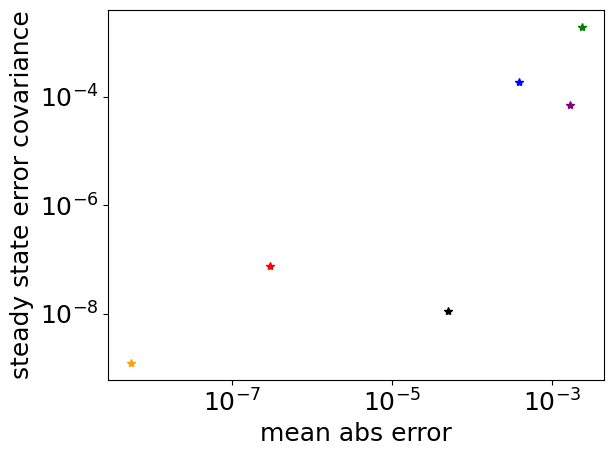

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(mean_err)):
    ax.plot( np.array(mean_err)[i], np.diag(P_ss)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('mean abs error')
ax.set_ylabel('steady state error covariance')

Text(0, 0.5, 'steady state error covariance')

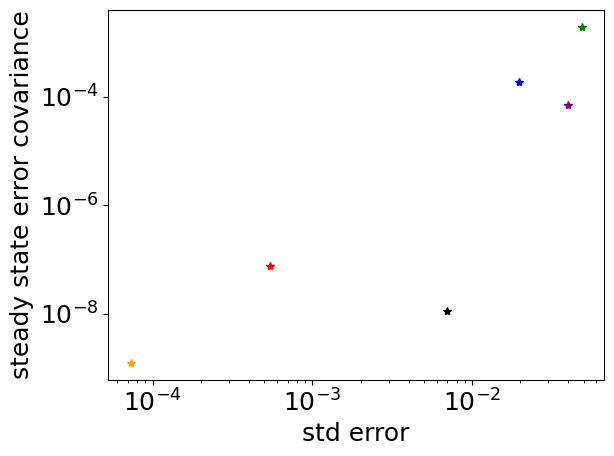

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(std_err)):
    ax.plot( np.array(std_err)[i], np.diag(P_ss)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlabel('std error')
ax.set_ylabel('steady state error covariance')

# Observability matrix

In [32]:
O = C
n = C.shape[0]
for i in range(0, 100):
    O = np.vstack((O,  O[-n:,:]@A))

# Observability Gramian

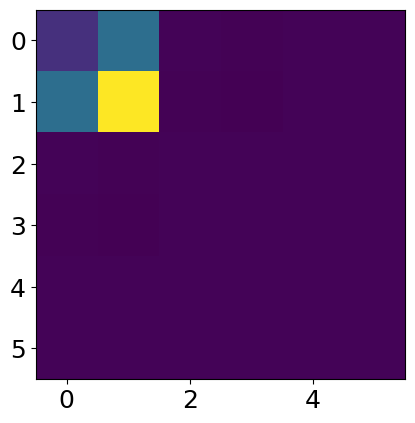

In [33]:
Wo = O.T@O

plt.imshow(Wo)

# Eigenvalues of Wo

In [34]:
eigvals, eigvecs = np.linalg.eig(Wo)

In [35]:
# Sort eigenvalues from largest to smallest
ixsort = np.argsort(eigvals)[::-1]

In [36]:
eigvals[ixsort]

array([4.15498310e+07, 1.23435394e+05, 3.45943565e+03, 5.76646080e+01,
       2.50643483e+01, 4.25057638e+00])

In [37]:
np.round( eigvecs[:, ixsort], 2)

array([[ 0.34, -0.94,  0.  ,  0.06,  0.  ,  0.03],
       [ 0.94,  0.34,  0.  , -0.01,  0.  , -0.01],
       [-0.  ,  0.02,  0.  ,  0.64,  0.  , -0.77],
       [-0.01,  0.06,  0.  ,  0.77,  0.  ,  0.64],
       [ 0.  ,  0.  , -0.15,  0.  , -0.99,  0.  ],
       [ 0.  ,  0.  , -0.99,  0.  ,  0.15,  0.  ]])

# Exercises

1. Is the system fully observable?
2. What are the most observable states?
3. What are the least observable states?
4. Are the errors for the most observable states smallest?

# Fisher Information

In [38]:
inv_kFIM = np.linalg.inv(Wo)

In [39]:
np.round(inv_kFIM, 2)

array([[ 0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  ],
       [-0.  ,  0.  ,  0.15, -0.11,  0.  ,  0.  ],
       [ 0.  , -0.  , -0.11,  0.11, -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.04, -0.01],
       [-0.  , -0.  , -0.  , -0.  , -0.01,  0.  ]])

Text(0, 0.5, 'inv (kFIM) -- a thing correlated\n with the Fisher Information^-1')

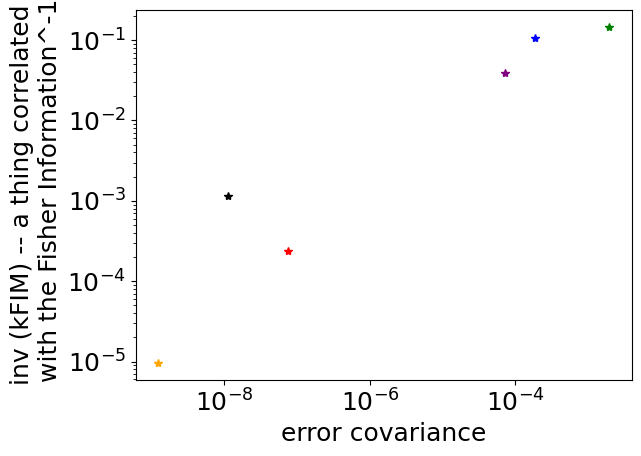

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(std_err)):
    ax.plot( np.diag( P_ss )[i], np.diag(inv_kFIM)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('error covariance')
ax.set_ylabel('inv (kFIM) -- a thing correlated\n with the Fisher Information^-1')

# Exercises

1. Update the FIM calculation to include R
2. By how much would adding the acceleration measurements (with noise stdev=0.00005) reduce the expected arror covariance?

In [77]:
Rmini = np.diag( np.array(v)**2 )

In [78]:
Rmini

array([[1.e-04, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e-06, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 4.e-02, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 4.e-02]])

In [79]:
R = np.zeros([O.shape[0], O.shape[0]])

In [80]:
num_measurements = int( O.shape[0]/len(v) )
for i in range(num_measurements):
    ix = i*len(v)
    R[ix:ix+len(v),ix:ix+len(v)] = Rmini

In [81]:
FIM = O.T@np.linalg.inv(R)@O
inv_kFIM = np.linalg.inv(FIM)

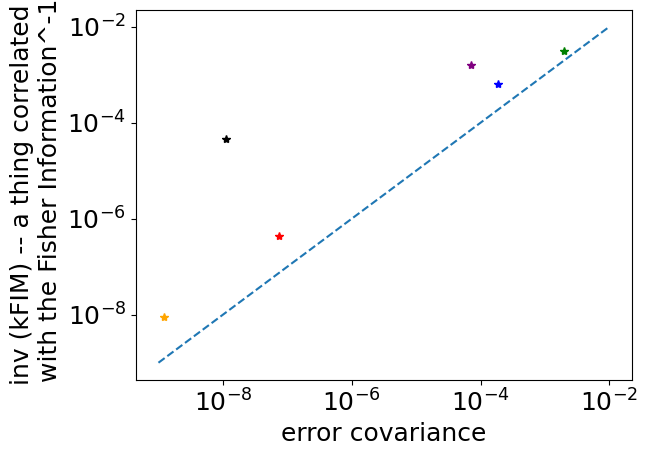

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(std_err)):
    ax.plot( np.diag( P_ss )[i], np.diag(inv_kFIM)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('error covariance')
ax.set_ylabel('inv (kFIM) -- a thing correlated\n with the Fisher Information^-1')

xline = np.logspace(-9, -2, 5)
ax.plot(xline, xline, '--')